In [1]:
import torch 
import torchvision 
from torch.utils.data import  DataLoader,datasets,Subset
from torchvision import transforms, datasets
import timm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torchvision.models as models
from torch.autograd import Variable
#import torchtext
#from torchtext.data import get_tokenizer

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

# Functions

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

def Load_triplet(triplet,images):
    tokenizer = get_tokenizer("basic_english")
    ids = tokenizer(triplet)
    images = images[0].__getitem__
    anchor = ids[0]
    truthy = ids[1]
    falsy = ids[2]
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
    
    print(anchor)

# Hyperperameters

In [4]:
num_epochs = 15
num_classes = 2
learning_rate = 0.001

# Main stuff

In [5]:
test_triplets = pd.read_csv('task4_be9ai3nsdj/test_triplets.txt',delimiter="\t",header=None)
train_triplets = pd.read_csv('task4_be9ai3nsdj/train_triplets.txt',delimiter="\t",header=None)

In [6]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(255),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder('task4_be9ai3nsdj/', transform = transform)

In [19]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=False)
# images, labels = next(iter(dataloader))
# plt.imshow(images[5].permute(1, 2, 0) )
# images.is_cuda

In [20]:
vision_model = timm.create_model('resnet18', pretrained=True)
vision_model.reset_classifier(0)

In [ ]:
%%time

i = 0
feature_list = []

iterables = iter(dataloader)

while i < 200:
    images, labels = next(iterables)
    
    features = vision_model(images)
    feature_list.append(features.detach().numpy())
    
    i+=1

In [43]:
feature_list_np = np.array(feature_list).reshape(10000, 512)

In [44]:
np.save('features_', feature_list_np)

In [18]:
features.detach().numpy().shape

(20, 512)

In [10]:
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

In [11]:
#Load_triplet(train_triplets[0][0],dataset)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet18(pretrained=True)
layer = model._modules.get('avgpool')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
def get_vector(image):
    features = torch.zeros(512)

    def copy_data(m, i, o):
        features.copy_(o.data)

    h = layer.register_forward_hook(copy_data)

    # 6. Run the model on our transformed image
    model(Variable(image.unsqueeze(0)))
    # 7. Detach our copy function from the layer
    h.remove()
    
    return features

In [27]:
feature1 = get_vector(images[0])
feature2 = get_vector(images[1])

RuntimeError: output with shape [512] doesn't match the broadcast shape [1, 512, 1, 512]

NameError: name 'feature1' is not defined

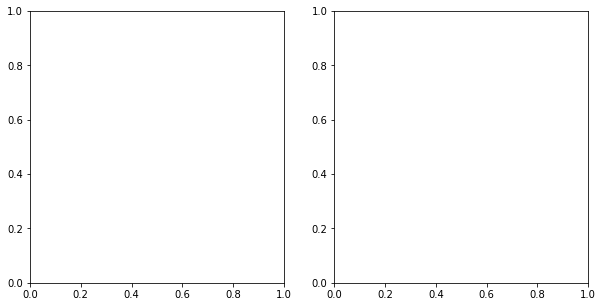

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(feature1[0,:,0,:])
ax[1].imshow(feature2[0,:,0,:])
plt.show()

In [18]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
cos(feature1, feature2)

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        ...,

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])